In [1]:

# Import required libraries
import os 
import numpy as np
import matplotlib.pyplot as plt
from synthetic_signal_dataset import get_dataloader
import warnings
import torch 
from model import *

### 🔧 Configuration, Data Generation, and Model Training


In [ ]:

# ----------------------------------
# 📦 Configuration
# ----------------------------------
config = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    "output_dir": './outputs/',
    "run_name": 'run_probabilistic_2d',
    "n_samples": 300000,
    "batch_size": 32,
    "n_features": 4,
    "n_timesteps": 600,
    "image_size": 64,
    "transform_method": 'all',
    "seed": 42,
    "latent_dim": 32,
    "n_components": 4,
    "learning_rate": 1e-3,
    "num_epochs": 5,
    "beta": 0.1
}

# ----------------------------------
# 🗂 Output Directory and Logging
# ----------------------------------
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(config["output_dir"], config["run_name"])
os.makedirs(output_dir, exist_ok=True)

log_file = setup_logging(output_dir)
logging.info(f'Using device: {config["device"]}')

# ----------------------------------
# 📊 Data Generation
# ----------------------------------
logging.info('Generating synthetic data...')
train_size = int(0.8 * config["n_samples"])
val_size = config["n_samples"] - train_size

train_loader = get_dataloader(
    n_samples=train_size,
    batch_size=config["batch_size"],
    n_features=config["n_features"],
    n_timesteps=config["n_timesteps"],
    image_size=config["image_size"],
    transform_method=config["transform_method"],
    seed=config["seed"],
    num_workers=12,
    shuffle=True
)

val_loader = get_dataloader(
    n_samples=val_size,
    batch_size=config["batch_size"],
    n_features=config["n_features"],
    n_timesteps=config["n_timesteps"],
    image_size=config["image_size"],
    transform_method=config["transform_method"],
    seed=config["seed"] + 1,
    num_workers=4,
    shuffle=False
)

logging.info(f'Generated {train_size} training samples and {val_size} validation samples')

# ----------------------------------
# 🧠 Model Setup and Training
# ----------------------------------
model = VAE(
    latent_dim=config["latent_dim"],
    input_channels=4,
    image_size=config["image_size"],
    signal_length=config["n_timesteps"], 
    n_components=config["n_components"]
)

optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

train_model(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader, 
    optimizer=optimizer, 
    num_epochs=config["num_epochs"], 
    device=config["device"], 
    log_dir=output_dir, 
    beta=config["beta"] 
)

logging.info('Training completed')



### 🖼️ Visualize a Batch of Synthetic Signals and Their Image Representations


In [3]:
# Suppress specific warnings from pyts
warnings.filterwarnings('ignore', category=UserWarning, module='pyts')

# ----------------------------------
# 📦 Load Data for Visualization
# ----------------------------------

# Create a small dataloader for previewing examples
dataloader = get_dataloader(
    n_samples=10, 
    batch_size=5,
    n_timesteps=config["n_timesteps"],
    image_size=config["image_size"],
    transform_method=config["transform_method"]
)

# Get a single batch
batch = next(iter(dataloader))
signals = batch['signal']  # Shape: (batch_size, n_timesteps)
images = batch['image']    # Shape: (batch_size, channels, H, W)


In [4]:
# ----------------------------------
# 🧠 Initialize Model Architecture
# ----------------------------------

# Choose between 2D and 1D model architecture
model = VAE(  # Uncomment this if you're using the 2D VAE
    latent_dim=config["latent_dim"],
    input_channels=4,
    image_size=config["image_size"],
    signal_length=config["n_timesteps"], 
    n_components=config["n_components"]
 )

#model = VAE1D(  # Currently using VAE1D
#    latent_dim=config["latent_dim"],
#    signal_length=config["n_timesteps"], 
#    n_components=config["n_components"]
#)

# ----------------------------------
# 💾 Load Pretrained Weights
# ----------------------------------

output_dir = os.path.join(config['output_dir'], config['run_name'])
checkpoint_path = os.path.join(output_dir, "best_model.pth")

# Load full checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config["device"])

# Optionally log metadata
logging.info(f"Checkpoint keys: {list(checkpoint.keys())}")

# Load model weights
model.load_state_dict(checkpoint["model_state_dict"])
model.to(config["device"])
model.eval()

logging.info("Model loaded successfully")



2025-05-08 17:42:23,131 - INFO - Checkpoint keys: ['model_state_dict', 'latent_dim', 'signal_length', 'n_components', 'input_channels', 'image_size']
2025-05-08 17:42:23,147 - INFO - Model loaded successfully


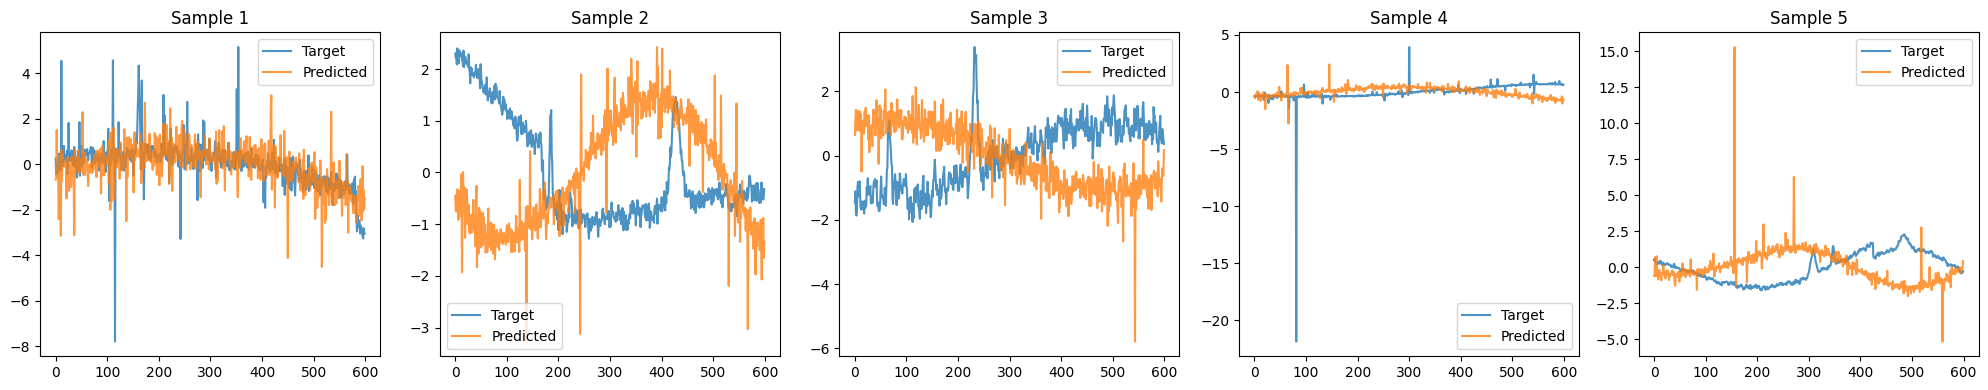

In [5]:
# 🔮 Predict signals from the input batch
signals = model.predict_signals(batch, return_mean=False)

# Remove unnecessary channel dimension if present (e.g., shape [B, 1, T])
if signals.ndim == 3:
    signals = signals[:, 0, :]

# ----------------------------------
# 🖼️ Plot Target vs. Predicted Signals
# ----------------------------------

fig, axs = plt.subplots(1, len(signals), figsize=(20, 4))

for i in range(len(signals)):
    # Plot target signal
    axs[i].plot(batch['signal'][i].detach().numpy(), label='Target', alpha=0.8)
    
    # Plot predicted signal
    axs[i].plot(signals[i].detach().numpy(), label='Predicted', alpha=0.8)
    
    axs[i].set_title(f'Sample {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()
